In [2]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt


C:\Users\jhroe\AppData\Local\Temp\ipykernel_23660\2609811891.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [11]:
data_path = f"{os.getcwd()}/Data/"

In [1]:
# Convert 1d vector of indices to 2d coordinates, by specifying the height of the image
def index_to_coord(vec, height):
    y = vec//height
    x = vec%height
    return x,y

# convert boolean mask of the cell to black and white image
def bound_to_2d(bound_vec, width, height):
    b = np.zeros(height*width, dtype=np.int8)
    b[bound_vec] = 1
    b = np.reshape(b,[width,height]).T
    return b

# return the pixel that is closest to the center of the cell
def avg_idx(xs, ys):
    return round(np.mean(xs)), round(np.mean(ys))

# convert empty celltype to unknown celltype and get rid of matlab formatting
def emp_to_nan(l):
    res = np.array([])
    for i in range(len(l)):
        try:
            res = np.append(res, l[i][0][0])
        except:
            res = np.append(res, 'Unknown')
    return res


In [4]:
# create a dictionary that contains all the information of all the patients
master_dict = {}
for i in range(1, 417):
    no = format(i, '03d')
    pat = 'LUAD_D' + no
    path_celltype = f'{data_path}/raw/LUAD_IMC_CellType/{pat}.mat'
    path_seg_nms = f'{data_path}/raw/LUAD_IMC_Segmentation/{pat}/nuclei_multiscale.mat'
    celltype = loadmat(path_celltype)  # load mat-file
    segm_nms = loadmat(path_seg_nms)  # load mat-file

    patientdict = {}
    height, width = segm_nms['nucleiImage'].shape
    celltype_list = emp_to_nan(celltype['cellTypes'])

    for cellno, cell in enumerate(segm_nms['Boundaries'][0]):
        xcell,ycell = index_to_coord(cell, height)
        x,y = avg_idx(xcell, ycell)
        c_type = celltype_list[cellno]
        patientdict[cellno] = np.array([x,y,c_type])
        
    master_dict[pat] = patientdict

master_dict['LUAD_D001']

{0: array(['93', '159', 'Cancer'], dtype='<U11'),
 1: array(['74', '186', 'Tc'], dtype='<U11'),
 2: array(['167', '131', 'Tc'], dtype='<U11'),
 3: array(['134', '116', 'Cancer'], dtype='<U11'),
 4: array(['142', '122', 'Endothelial cell'], dtype='<U16'),
 5: array(['133', '152', 'Cl MAC'], dtype='<U11'),
 6: array(['153', '101', 'B cell'], dtype='<U11'),
 7: array(['91', '179', 'Th'], dtype='<U11'),
 8: array(['141', '197', 'Cancer'], dtype='<U11'),
 9: array(['144', '168', 'Unknown'], dtype='<U11'),
 10: array(['120', '149', 'Th'], dtype='<U11'),
 11: array(['170', '107', 'Alt MAC'], dtype='<U11'),
 12: array(['197', '140', 'Cancer'], dtype='<U11'),
 13: array(['198', '76', 'Cancer'], dtype='<U11'),
 14: array(['130', '164', 'Cancer'], dtype='<U11'),
 15: array(['114', '173', 'Cancer'], dtype='<U11'),
 16: array(['178', '87', 'Cancer'], dtype='<U11'),
 17: array(['115', '164', 'Cl MAC'], dtype='<U11'),
 18: array(['196', '69', 'Cancer'], dtype='<U11'),
 19: array(['181', '97', 'Treg']

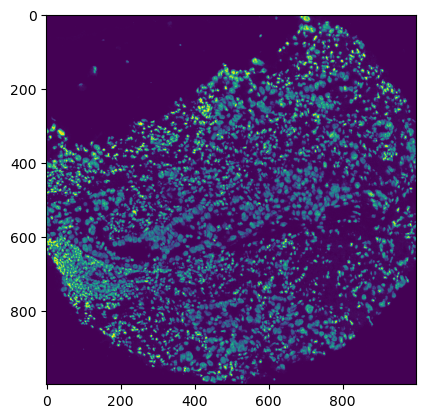

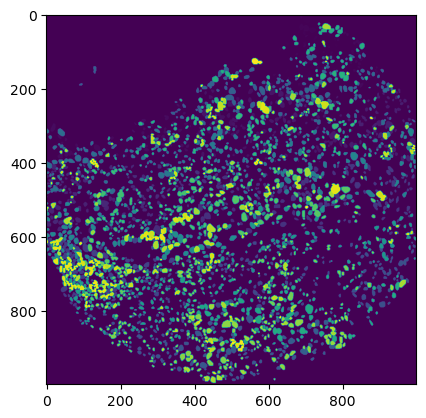

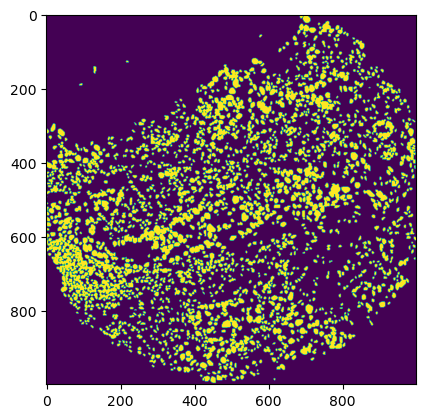

In [5]:
# example images of cells to make sure converting went well
plt.imshow(segm_nms['nucleiImage'])
plt.show()

plt.imshow(segm_nms['nucleiOccupancyIndexed'])
plt.show()
plt.imshow(segm_nms['occupancy_image'])

plt.show()


In [6]:
# Load in first patient
pi = pd.read_excel(f'{data_path}/raw/LUAD Clinical Data.xlsx')
patientinfocols = pi.columns
df = pd.DataFrame(master_dict['LUAD_D001']).T
df.columns = ['x_pix', 'y_pix', 'celltype']

df = pd.concat([df, pd.concat([pi[pi['Key'] == 'LUAD_D001']]*len(df), ignore_index=True)], axis=1)
df['ID'] = df['Key'].str[5:] + '_' + df.index.astype(str)

# stack rest of the patients on top of original patient df to create one big df
# index is cell number per patient

for i in range(2, 417):
    no = format(i, '03d')
    pat = 'LUAD_D' + no
    df2 = pd.DataFrame(master_dict[pat]).T
    df2.columns = ['x_pix', 'y_pix', 'celltype']

    df2 = pd.concat([df2, pd.concat([pi[pi['Key'] == pat]]*len(df2), ignore_index=True)], axis=1)
    df2['ID'] = df2['Key'].str[5:] + '_' + df2.index.astype(str)
    df = pd.concat([df,df2], axis=0)


In [13]:
# Get date
date = datetime.now().strftime("%Y%m%d")
# save full df to csv
df.to_csv(f"{data_path}/celldata/celldata_all_clean_{date}.csv", index = False)

In [14]:
# Format the data for celldistance py script
celldata = df[['ID', 'celltype','Key', 'x_pix', 'y_pix']]
celldata = celldata.rename(columns={"Key":"Patient_ID","ID": "cellID", 'x_pix':'Location_Center_X', 'y_pix':'Location_Center_Y'})
celldata.to_csv(f"{data_path}/celldata/celldata_{date}.csv", index = False)

celldata

,cellID,celltype,Patient_ID,Location_Center_X,Location_Center_Y
0,D001_0,Cancer,LUAD_D001,93,159
1,D001_1,Tc,LUAD_D001,74,186
2,D001_2,Tc,LUAD_D001,167,131
3,D001_3,Cancer,LUAD_D001,134,116
4,D001_4,Endothelial cell,LUAD_D001,142,122
...,...,...,...,...,...
2881,D416_2881,Cl MAC,LUAD_D416,281,879
2882,D416_2882,Unknown,LUAD_D416,385,907
2883,D416_2883,Cancer,LUAD_D416,363,992
2884,D416_2884,Cancer,LUAD_D416,357,994
